# PyTorch Simulator

In [17]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Parameters for the simulation
expected_return = 0.25  # 25% expected return
risk_free_rate = 0.03  # 2.70% risk-free rate
std_deviation = 0.20  # 20% standard deviation
time_horizon = 30  # 30 years
trading_days = 252  # Number of trading days in a year
dt = 1. / trading_days  # Time step for trading days
num_simulations = 1_000  # Number of simulations
# Simulate multiple random walks for mutual fund performance using PyTorch matrix operations
time_steps = int(time_horizon * trading_days)
# Define batch size to fit within GPU memory
batch_size = 100  # Adjust this value based on your GPU memory capacity

# Set random seed for reproducibility
torch.manual_seed(42)


Using cuda device


In [18]:
import psutil
import gc

# Clean unused memory
gc.collect()
torch.cuda.empty_cache()

# Get the memory usage
memory_info = psutil.virtual_memory()

# Display the memory usage
print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Memory usage percentage: {memory_info.percent}%")

# Print GPU memory usage
if device == "cuda":
    gpu_memory_allocated = torch.cuda.memory_allocated(0) / (1024 ** 3)
    gpu_memory_reserved = torch.cuda.memory_reserved(0) / (1024 ** 3)
    print(f"Allocated GPU memory: {gpu_memory_allocated:.2f} GB")
    print(f"Reserved GPU memory: {gpu_memory_reserved:.2f} GB")
else:
    print("No GPU available")

Total memory: 376.55 GB
Available memory: 318.08 GB
Used memory: 53.08 GB
Memory usage percentage: 15.5%
Allocated GPU memory: 0.57 GB
Reserved GPU memory: 0.62 GB


In [19]:
# Initialize an empty list to store the price matrices
price_matrices = []

# Generate random normal returns for all simulations in batches and move to the GPU
for i in range(0, num_simulations, batch_size):
    current_batch_size = min(batch_size, num_simulations - i)
    returns_matrix = torch.normal(
        mean=(expected_return - risk_free_rate) * dt, 
        std=std_deviation * torch.sqrt(torch.tensor(dt)),
        size=(current_batch_size, time_steps)
    ).to(device)
    # Calculate cumulative returns and convert to mutual fund prices
    price_matrix_batch = 100 * torch.exp(torch.cumsum(returns_matrix, dim=1))  # Initial value of 100 for all simulations
    
    # Clean unused memory
    torch.cuda.empty_cache()
    price_matrices.append(price_matrix_batch)

# Concatenate all batches to form the final price matrix
price_matrix = torch.cat(price_matrices, dim=0)

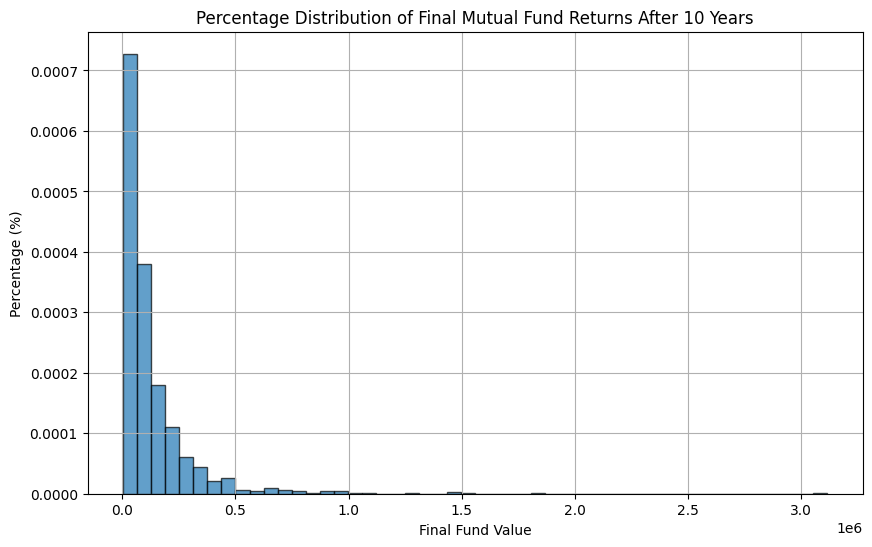

In [20]:

# Move the final prices back to the CPU for visualization
final_prices = price_matrix[:, -1].cpu().numpy()  # Convert to numpy for visualization

# Plotting the histogram of final returns with percentages
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(final_prices, bins=50, edgecolor='black', alpha=0.7, density=True)

# Convert counts to percentages
counts_percentage = counts * 100  # Convert density to percentage

# Redraw the histogram with percentages
plt.clf()  # Clear the previous plot
plt.bar(bins[:-1], counts_percentage, width=np.diff(bins), edgecolor="black", align="edge", alpha=0.7)

plt.title("Percentage Distribution of Final Mutual Fund Returns After 10 Years")
plt.xlabel("Final Fund Value")
plt.ylabel("Percentage (%)")
plt.grid(True)
plt.show()

In [21]:
# Simulate multiple random walks for mutual fund performance using PyTorch
time_steps = int(time_horizon * trading_days)
price_simulations = []

for i in range(num_simulations):
    returns_torch = torch.normal(mean=(expected_return - risk_free_rate) * dt, 
                                 std=std_deviation * torch.sqrt(torch.tensor(dt)), 
                                 size=(time_steps,))
    price_torch = 100 * torch.exp(torch.cumsum(returns_torch, dim=0))  # Initial value of 100
    price_simulations.append(price_torch.numpy())

# Convert to numpy for visualization
dates = pd.date_range(start="2024-09-27", periods=time_steps, freq='B')  # Only trading days (weekdays)

# Plotting multiple lines
plt.figure(figsize=(10, 6))

for i in range(num_simulations):
    plt.plot(dates, price_simulations[i], label=f"Mutual Fund {i+1}")

plt.title("Simulated Multiple Mutual Fund Performances Over Time (Torch)")
plt.xlabel("Date")
plt.ylabel("Fund Value")
plt.legend()
plt.grid(True)
plt.show()